# Model inference

Notebook to understand how inference works and how the model can be deployed onto mobilenet v2 and subsequently 
re-trained with custom datasets.

In [41]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pprint

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import math
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feaf2b12710>
Traceback (most recent call last):
  File "/opt/conda/envs/pytorch-py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/pytorch-py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/conda/envs/pytorch-py37/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/envs/pytorch-py37/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/envs/pytorch-py37/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [2]:
sys.path.append('../lib/')
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.loss import JointsMSELoss
from core.function import validate
from utils.utils import create_logger
from utils.vis import save_batch_image_with_joints, save_batch_heatmaps
from core.inference import get_final_preds, get_max_preds

In [3]:
import dataset
import models

### Setup model

In [4]:
update_config('../experiments/coco/resnet50/256x192_d256x3_adam_lr1e-3.yaml')
config.TEST.MODEL_FILE='../models/pytorch/pose_coco/pose_resnet_50_256x192.pth.tar'

../lib/core/config.py:163: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [5]:
print(f'Configuring model {config.MODEL.NAME}')
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(
    config, is_train=False
)
config.DATASET.ROOT = os.path.join('../', config.DATASET.ROOT)

Configuring model pose_resnet


In [6]:
model

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [7]:
print(f'Loading model from {config.TEST.MODEL_FILE}')
model.load_state_dict(torch.load(config.TEST.MODEL_FILE, map_location=torch.device('cpu')))

Loading model from ../models/pytorch/pose_coco/pose_resnet_50_256x192.pth.tar


<All keys matched successfully>

### Define loss function (criterion) and optimizer

In [8]:
criterion = JointsMSELoss(
    use_target_weight=config.LOSS.USE_TARGET_WEIGHT
).to(device='cpu')

/opt/conda/envs/pytorch-py37/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Setup data loader

* This is using a hacked val2017 annotations file (none of the key points have been setup!)

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

In [16]:
config.DATASET.TEST_SET = 'test'
test_dataset = eval('dataset.'+config.DATASET.DATASET)(
        config,
        config.DATASET.ROOT,
        config.DATASET.TEST_SET,
        False,
        transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])
    )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [24]:
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.TEST.BATCH_SIZE_CPU,  # config.TEST.BATCH_SIZE*len(gpus),
        shuffle=False,
        num_workers=config.CPU_WORKERS,  # config.WORKERS,
        pin_memory=True
    )

### Image processing functions

In [45]:
def show_image(batch_image, batch_joints, batch_joints_vis,
                                 file_name, nrow=8, padding=2):
    
    grid = torchvision.utils.make_grid(batch_image, nrow, padding, True)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    ndarr = ndarr.copy()

    nmaps = batch_image.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height = int(batch_image.size(2) + padding)
    width = int(batch_image.size(3) + padding)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            joints = batch_joints[k]
            joints_vis = batch_joints_vis[k]

            for joint, joint_vis in zip(joints, joints_vis):
                joint[0] = x * width + padding + joint[0]
                joint[1] = y * height + padding + joint[1]
                if joint_vis[0]:
                    cv2.circle(ndarr, (int(joint[0]), int(joint[1])), 2, [255, 0, 0], 2)
            k = k + 1
    
    plt.imshow(ndarr)

In [46]:
def save_debug_images(config, input, meta, target, joints_pred, output, prefix):
#     if not config.DEBUG.DEBUG:
#         return

#     if config.DEBUG.SAVE_BATCH_IMAGES_GT:
#         save_batch_image_with_joints(
#             input, meta['joints'], meta['joints_vis'],
#             '{}_gt.jpg'.format(prefix)
#         )
#     if config.DEBUG.SAVE_BATCH_IMAGES_PRED:
        save_batch_image_with_joints(
            input, joints_pred, meta['joints_vis'],
            '{}_pred.jpg'.format(prefix)
        )
#     if config.DEBUG.SAVE_HEATMAPS_GT:
#         save_batch_heatmaps(
#             input, target, '{}_hm_gt.jpg'.format(prefix)
#         )
#     if config.DEBUG.SAVE_HEATMAPS_PRED:
        save_batch_heatmaps(
            input, output, '{}_hm_pred.jpg'.format(prefix)
        )

### Test trained model

Note that this is a visual test and not a formal accuracy test

In [47]:
def test(config, test_loader, test_dataset, model, criterion, output_dir='',
             tb_log_dir='', writer_dict=None):
#    batch_time = AverageMeter()
#     losses = AverageMeter()
#     acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    num_samples = len(test_dataset)
    all_preds = np.zeros((num_samples, config.MODEL.NUM_JOINTS, 3),
                         dtype=np.float32)
    all_boxes = np.zeros((num_samples, 6))
    image_path = []
    filenames = []
    imgnums = []
    idx = 0
    with torch.no_grad():
#         end = time.time()
        for i, (input, target, target_weight, meta) in enumerate(test_loader):
            # compute output
            output = model(input)
            print(f'Model returned tensor of shape {output.shape}')
#             if config.TEST.FLIP_TEST:
#                 # this part is ugly, because pytorch has not supported negative index
#                 # input_flipped = model(input[:, :, :, ::-1])
#                 input_flipped = np.flip(input.cpu().numpy(), 3).copy()
#                 input_flipped = torch.from_numpy(input_flipped).to(device='cpu')   # .cuda()
#                 output_flipped = model(input_flipped)
#                 output_flipped = flip_back(output_flipped.cpu().numpy(),
#                                            val_dataset.flip_pairs)
#                 output_flipped = torch.from_numpy(output_flipped.copy()).to(device='cpu')  # .cuda()

#                 # feature is not aligned, shift flipped heatmap for higher accuracy
#                 if config.TEST.SHIFT_HEATMAP:
#                     output_flipped[:, :, :, 1:] = \
#                         output_flipped.clone()[:, :, :, 0:-1]
#                     # output_flipped[:, :, :, 0] = 0

#                 output = (output + output_flipped) * 0.5

#             # target = target.cuda(non_blocking=True)
#             # target_weight = target_weight.cuda(non_blocking=True)

#             loss = criterion(output, target, target_weight)

            num_images = input.size(0)
#             # measure accuracy and record loss
#             losses.update(loss.item(), num_images)
#             _, avg_acc, cnt, pred = accuracy(output.cpu().numpy(),
#                                              target.cpu().numpy())

#             acc.update(avg_acc, cnt)

#             # measure elapsed time
#             batch_time.update(time.time() - end)
#             end = time.time()

            c = meta['center'].numpy()
            s = meta['scale'].numpy()
            score = meta['score'].numpy()

            preds, maxvals = get_final_preds(
                config, output.clone().cpu().numpy(), c, s)

            all_preds[idx:idx + num_images, :, 0:2] = preds[:, :, 0:2]
            all_preds[idx:idx + num_images, :, 2:3] = maxvals
            # double check this all_boxes parts
            all_boxes[idx:idx + num_images, 0:2] = c[:, 0:2]
            all_boxes[idx:idx + num_images, 2:4] = s[:, 0:2]
            all_boxes[idx:idx + num_images, 4] = np.prod(s*200, 1)
            all_boxes[idx:idx + num_images, 5] = score
            image_path.extend(meta['image'])
            if config.DATASET.DATASET == 'posetrack':
                filenames.extend(meta['filename'])
                imgnums.extend(meta['imgnum'].numpy())

            idx += num_images

#             if i % config.PRINT_FREQ == 0:
#                 msg = 'Test: [{0}/{1}]\t' \
#                       'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
#                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
#                       'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
#                           i, len(test_loader), batch_time=batch_time,
#                           loss=losses, acc=acc)
#                 logger.info(msg)

            pred, _ = get_max_preds(output.numpy())

            prefix = '{}_{}'.format(os.path.join(output_dir, 'val'), i)
            save_debug_images(config, input, meta, target, pred*4, output,
                              prefix)

#         name_values, perf_indicator = val_dataset.evaluate(
#             config, all_preds, output_dir, all_boxes, image_path,
#             filenames, imgnums)

#         _, full_arch_name = get_model_name(config)
#         if isinstance(name_values, list):
#             for name_value in name_values:
#                 _print_name_value(name_value, full_arch_name)
#         else:
#             _print_name_value(name_values, full_arch_name)

#         if writer_dict:
#             writer = writer_dict['writer']
#             global_steps = writer_dict['valid_global_steps']
#             writer.add_scalar('valid_loss', losses.avg, global_steps)
#             writer.add_scalar('valid_acc', acc.avg, global_steps)
#             if isinstance(name_values, list):
#                 for name_value in name_values:
#                     writer.add_scalars('valid', dict(name_value), global_steps)
#             else:
#                 writer.add_scalars('valid', dict(name_values), global_steps)
#             writer_dict['valid_global_steps'] = global_steps + 1

    return output

### Visualise ground truth on image

In [48]:
input, target, target_weight, meta = next(iter(test_loader))

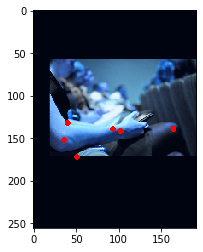

In [49]:
show_image(
    input, meta['joints'], meta['joints_vis'],
    '{}_gt.jpg'.format('test'))

### Predict joints from trained model

In [51]:
output = test(config, test_loader, test_dataset, model, criterion) #, final_output_dir, tb_log_dir)

Model returned tensor of shape torch.Size([1, 17, 64, 48])
save_batch_image_with_joints(): Saving to val_0_pred.jpg
save_batch_heatmaps(): Saving to val_0_hm_pred.jpg


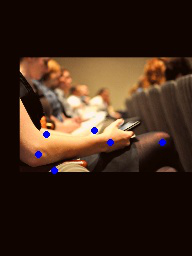

In [65]:
saved_pred_image = Image.open('val_0_pred.jpg')
saved_pred_image